<a href="https://colab.research.google.com/github/ozgung/microgpt-Turkce/blob/main/microgpt_T%C3%BCrk%C3%A7e.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MicroGPT-Türkçe
Kod: Andrej Karphaty

Türkçe anlatım ve grafikler: Özgün Genç

> GPT’yi saf, bağımlılıksız Python ile eğitmenin ve çıkarım yapmanın en “atomik” yolu.\
> Bu dosya algoritmanın tamamı.\
> Geri kalan her şey sadece verimlilik.\
> @karpathy

200 satırda GPT eğiten ve çıkarım (inference) yapan microgpt projesinin Türkçe açıklamasına hoşgeldiniz. Aşağıda kodu aşama aşama v satır satır inceleyeceğiz.

Andrej Karphaty bu kodu ve blog yazısını yakın zamanda yayımladı (Şubat 2026). Kodda neredeyse hiç değişiklik yapmadım ama bol bol yorum ekledim. Ayrıca kodda olan biten her şeyi ve kullanılan teknikleri uzun uzun Türkçe olarak anlattım. Amacım günümüz için bu kadar önemli bir teknolojiyi anlamak için bütün engelleri en aza indirmek ve gizemleri ortadan kaldırmaya çalışmak. Umarım anlaşılır bir yazı olmuştur.

Orijinal blog posttaki bir çok ayrıntıyı da eklemeye çalıştım ama ayrıca oraya bakmanızı da tavsiye ederim. Ayrıca takıldığınız yerleri Colab ortamında okuyorsanız direkt yandaki Gemini'ya sorabilirsiniz.

İngilizce orijinal [Colab](https://colab.research.google.com/drive/1vyN5zo6rqUp_dYNbT4Yrco66zuWCZKoN?usp=sharing) ve
[Blog yazısına](https://karpathy.github.io/2026/02/12/microgpt/) linklerden ulaşabilirsiniz.

Hazırsanız başlayalım.



Bu proje en yalın haliyle Python kullanıyor ve dışarıdan hiçbir hazır kütüphane kullanmayacağız. Standart kütüphaneden de yalnızca logaritma (`math.log`) ve üstel fonksiyonlar (`math.exp`) ile rastgele sayı modülünü (`random`) import ederek başlıyoruz. `os.path.exists` ve `urllib.request.urlretrieve` fonksiyonlarını ise sadece örnek veri dosyasını indirmek için kullanıyoruz.

`random.seed(42)` rastgele sayıların her zaman aynı sırada üretilmesini sağlayarak bize yardımcı olacak. Böylece hep aynı sonuçları göreceğiz. Bu sadece geliştirme sırasında hataları kolay bulabilmemiz için kullanılan bir teknin. Normalde bu satırı kaldırabiliriz.

In [1]:
'''Translated to Turkish by ChatGPT from the orginal in English.'''
'''İngilizce orijinalinden ChatGPT ile Türkçe'ye çevrilmiştir.'''
'''https://colab.research.google.com/drive/1vyN5zo6rqUp_dYNbT4Yrco66zuWCZKoN?usp=sharing'''
'''https://karpathy.github.io/2026/02/12/microgpt/'''

import os       # os.path.exists
import math     # math.log, math.exp
import random   # random.seed, random.choices, random.gauss, random.shuffle
random.seed(42) # Kaos içinde düzen olsun

## Eğitim Verisi
Elimizde örnek olarak basit bir veriseti var. Linke tıklayarak içeriğini görebilirsiniz. Her satırda bir insan ismi olan bir liste bu. Aşağıda önce bu listeyi indirip `input.txt` dosyasına kaydediyoruz. Sonra dosyayı okuyup `docs` isimli listeyi oluşturuyoruz. 32033 elemanlı bu isim listesi eğitim için bizim veri setimiz olacak.

Gerçek GPT'de bu `docs` listesinin her elemanı bir dökümanı, örneğin bir web sayfasındaki metinleri içerecek. Bu örnekte ise basit bir örnek olarak insan isimleri kullanılmış.

In [2]:

# Bir giriş veri kümesi `docs` olsun: dokümanlardan oluşan liste[str] (ör. isimlerden oluşan bir veri kümesi)
if not os.path.exists('input.txt'):
    import urllib.request
    names_url = 'https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt' # isimler listesi
    urllib.request.urlretrieve(names_url, 'input.txt')
docs = [l.strip() for l in open('input.txt').read().strip().split('\n') if l.strip()] # dokümanlardan oluşan liste[str]
random.shuffle(docs) # listeyi rastgele karıştır
print(f"doküman sayısı: {len(docs)}")


doküman sayısı: 32033


# Tokenleştirme
Bu veri seti sözcüklerden yani harflerden oluşuyor. Fakat yapay öğrenme modeli için bize sayılar gerekiyor. Girdileri nasıl sayılara dönüştürebiliriz?

Basit bir yöntem her harfe bir sayı atamak. İngiliz alfabesinde **26 harf** var. Bir tane de dizinin başlangıcını tanımlayan özel bir sembol (token) tanımlıyoruz. Bu özel sembolünün ismi orijınal kodda `BOS` (Beginning of Sequence, Dizinin Başlangıcı) olarak isimlendirilmiş. Ben bunu başlangıç anlamında `BAS` olarak değiştirdim. Model bu `BAS` tokenini ayraç olarak kullanmayı öğrenecek. Farkli isimleri (dökümanları) bu şekilde birbirinden ayıracağız. Örnek:
`
[BAS, e, m, m, a, BAS]
`

Burada **token** kavramına da değinelim. Dokumanı ayırdıgımız bu parçacıklara genelde token adı veriliyor. Biz basitçe her **harf için bir token** gibi bir eşleştirme yaptık. Her tokeni de bir tamsayı ile temsil ettik (**token id**). Gerçek GPT'de daha etkili bir yol olarak harf gruplarını tokena çeviriyorlar. GPT4'ün kullandığı token dönüştürücüsü [tiktoken](https://github.com/openai/tiktoken)'a buradan ulaşabilirsiniz.

In [3]:
# Dizgileri ayrık sembollere çeviren ve geri dönüştüren bir Tokenizer olsun
uchars = sorted(set(''.join(docs))) # veri kümesindeki benzersiz karakterler token id’leri 0..n-1 olur
BAS = len(uchars) # özel “Dizinin Başlangıcı” (BAS) token’ı için token id
vocab_size = len(uchars) + 1 # toplam benzersiz token sayısı, +1 BAS içindir
print(f"sözlük boyutu: {vocab_size}")

sözlük boyutu: 27


## Otomatik Türev (AutoGrad)
Geldik matematiksel olarak en yoğun ve belki de asıl işi yapan kısma. Normalde `pytorch`, `JAX` gibi kütüphanelerin en büyük katkısı da bu.

Yapay Sinirsel Ağlar günümüzde **Geri Yayılım (Backpropagation)** algoritması ile eğitiliyor. Bütün ağı bir **hesaplama grafiği (computational graph)** olarak tanımlıyoruz. Bu ağ bizim **girdi**lerimizi (bu örnekte tokenlerimizi) ve **eğitilebilir model parametreleri**ni (**ağırlık** ve **bias** parametreleri gibi) alıyor. Model çıktısı ise yine bizim tanımladığımız bir **kayıp fonksiyonu**na (**Loss Function**) girerek tek bir sayıya (**Loss**) indirgeniyor. Eğitim sırasında bizim amacımız bu sayıyı (Loss) düşürmeye çalışmak. Bunu da model parametrelerini ufak ufak artırıp azaltarak yapıyoruz.

Peki hangi parametreleri artırıp hangilerini azaltmamız gerektiğini nereden bileceğiz? İşte **türev** bize bu ilişkiyi veriyor. Bir parametreyi "bir tık" artırdığımızda diğer bir değerinin ne kadar değişeceğinin ölçüsüne türev diyoruz. **Gradyan** ise türevin çok değişkenli haline verilen isim. Yani modeldeki bütün parametrelerin ne yönde değişmesi gerektiği **Gradyan vektörü** ile tanımlanıyor.

Tüm bu türev hesaplamalarını kendimiz yapabilirdik. Neyse ki **Otomatik Türev (AutoGrad)** denilen mucizevi yöntem sayesinde bütün bu türev hesapları otomatik yapılabiliyor. Biz ise sadece modeli tanımlayan o hesaplama grafiğini tanımlıyoruz. `Pytorch` gibi kütüphaneler sayesinde bu model tanımlama işini de bildiğimiz python fonksiyonları yazarak yapabiliyoruz. Autograd arka planda bizim yaptığımız bütün matematiksel **işlemlerin bir listesi**ni tutuyor ve türevlerini hesaplıyor. Matematiğe hiç elimizi bile sürmeden, hatta farkına bile varmadan matematiksel olarak hesaplaması gayet zor olacak şeyleri yapabiliyoruz. İşte Yapay Zekanın son yıllarda bu kadar hızlı ilerlemesinin sebeplerinden biri de bu oldu.

Bu tür kütüphaneleri kullananlar bilecektir ki modelin yapacağı işlemleri `forward` adlı bir fonksiyon ile tanımlıyoruz. Bu fonksiyon, modelin (hesaplama grafiğinin) **ileri yönde** (forward) yani girdilerden çıktıya doğru hangi işlemleri yapacağını tanımlıyor.

**Geri yayılım algoritması** ise **geri yönde**, yani kayıp değerinden başlayarak girdilere doğru geriye giderek her parametreye göre Lossun türevlerini oluşturuyor. Bu türevleri calculustaki **zincir kuralı**nı kullanarak yapıyor. Biz ise kodda `backward` fonksiyonunu çağırarak hesaplatıyoruz. İşte Autograd bu backward fonksiyonunu bizim için otomatik olarak yaratıyor.

**Zincir kuralı** şu şekilde:
$$\frac{\partial L}{\partial W}
=
\frac{\partial L}{\partial a}
\cdot
\frac{\partial a}{\partial z}
\cdot
\frac{\partial z}{\partial W}$$

Kayıp fonksiyonunun ($L$) parametrelere ($W$) göre türevi, ara katmanların geriye doğru yerel türevlerinin çarpımı şeklinde yazılabiliyor.

Fakat bu örnekte hazır hiçbir şey kullanmadığımız için **Autograd**'ı da kendimiz yazacağız. Korkmayın, sandığınızdan daha kolay.

### Ev Yapımı Autograd kodunun açıklaması

Öncelikle hesaplama grafiğimizdeki her bir düğümü temsilen `Value` sınıfı oluşturuyoruz. Bu sınıfın kendi içinde 4 farklı değer tutacak:

`data` bu düğümün hesaplanan skaler değeri,

`grad` lossun bu düğüme göre türevi,

`_children` (çocuklar) bu düğümün hesaplanmasında kullanılan (ondan önceki katmandan gelen) düğümler,
`_local_grads` ise bu düğümün çocuklarına göre yerel türevleri.

Bu `Value` nesneleri ile yaptığımız her matematiksel işlemde yeni bir `Value` yaratıyoruz. Örneğin `c = a + b` işlemini tanımladığımızda `c` `Value`'sunu yaratıyoruz. `c`'nin çocukları `a` ve `b` Value objeleri. `a` ve `b`'nin `.data` değişkeninin 3 ve 4 olduğunu düşünelim. `c.data` bu durumda 7 olarak hesaplanıyor. Bu hesaplamayı yaptığımız `+` işlemi `Value` sınıfına ait `__add__` fonksiyonunu kullanıyor. Biz bu `__add__` fonksiyonunu kodda kendimiz tanımlıyoruz. Fakat tanımlarken sadece toplama işlemi yapmakla kalmıyoruz. Yeni bir `c` `Value`'su yaratıp onu döndürüyoruz. `c.data` elbette `a + b` toplamı yani 7 oluyor. `c`'nin çocukları olarak `a` ve `b`'yi nüfusa kaydediyoruz. Ama en önemlisi toplama işlemi için `c`'nin `a`'ya ve `b`'ye göre **'yerel' türevleri**ni tanımlayıp onları da c'ye keydediyoruz. Toplama işlemi için her iki türev de 1 (a + b'nin a'ya ve b'ye göre türevleri 1 ve 1). Yapılan işlemin toplama olduğunu ayrıca kaydetmemize gerek yok. `.backward` geçişi için için bize sadece yerel türevler yetecek.

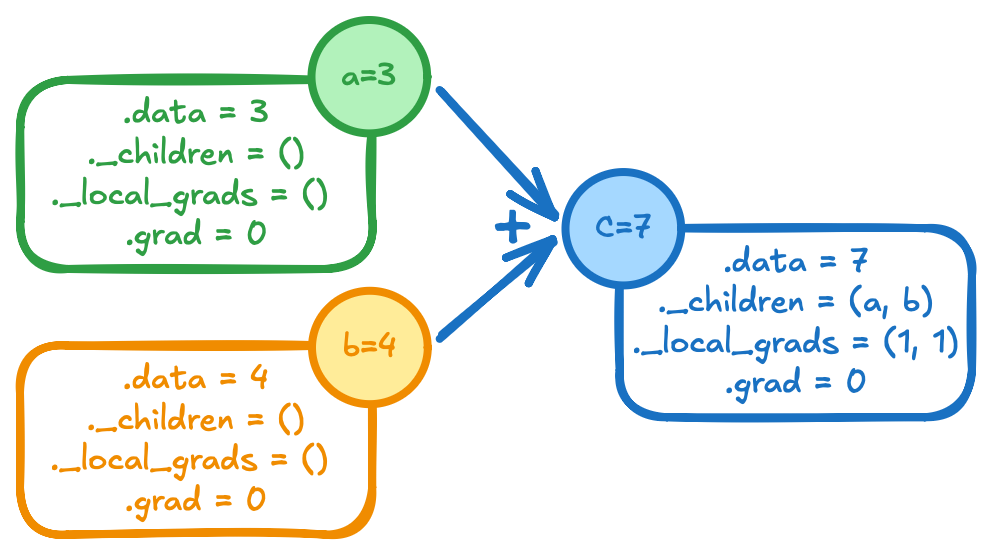

Bu fonksiyon tanımlamasını Value'ları kullanarak için yapmak istediğimiz bütün temel matematiksel işlemler için ayrı ayrı yapmamız gerekiyor. Bunların birleşiminden oluşan daha karmaşık işlemleri tekrar tanımlamamıza gerek yok. Buradaki GPT örneği için tablodaki tanımlar yetiyor:

| İşlem | İleri | Yerel Gradyanlar |
|-----------|----------|-------------------|
| `a + b`   | $$a + b$$ | $$\frac{\partial}{\partial a}=1,\quad \frac{\partial}{\partial b}=1$$ |
| `a * b`   | $$a \cdot b$$ | $$\frac{\partial}{\partial a}=b,\quad \frac{\partial}{\partial b}=a$$ |
| `a ** n`  | $$a^n$$ | $$\frac{\partial}{\partial a}=n a^{n-1}$$ |
| `log(a)`  | $$\ln(a)$$ | $$\frac{\partial}{\partial a}= \frac{1}{a}$$ |
| `exp(a)`  | $$e^a$$ | $$\frac{\partial}{\partial a}= e^a$$ |
| `relu(a)` | $$\max(0,a)$$ | $$\frac{\partial}{\partial a}= \mathbf{1}_{a>0}$$ |

### `.backward` fonksiyonu:
Dikkat ederseniz `Value` nesnelerini yaratırken (`__init__`) `.grad` değerlerini `0` olarak bıraktık. Bu degerleri yani gradyanları hesaplamak için `.backward` fonksiyonunu kullanacağız. Örneğin `loss.backward()` şeklinde çağırdığımızda en sondaki `loss` `Value`'sundan başlayarak, sondan başa doğru, hesaplama grafiğindeki bütün `Value` düğümlerini geziyoruz ve grad değerlerini zincir kuralını kullanarak hesaplıyoruz.

`backward` fonksiyonu içinde ilk yaptığımız iş bu tersine gezme sırasını oluşturmak. Buna tür bir sıralamaya tersine **topolojik sıralama** deniyor. Burada **DFS (Depth First Search, Derinlik Öncelikli Arama)** adlı klasik algoritmanın bir versiyonu kullanılarak topolojik sıralama bulunuyor (`topo`). DFS sırasında eğer bir düğümün bütün çocukları gezildiyse `topo` listesine ekliyoruz.

Loss'tan başlıyoruz ve onun kendine göre türevi 1. Yani en sonraki düğümün `.grad` değeri `1` oluyor.

Sonrasında `v in reversed(topo)` ile sondan başa doğru `v` düğümleri geziliyor. Burada yapılan işlem önemli.

`v`'nin `.grad` değeri **yerel gradyan**lar ile çarpılarak çocuklara aktarılıyor.  Burada çocukların mevcut gradyanına `v`'den yeni gelen gradyanlar **ekleniyor** (`+=`). Bunun sebebi ağda dallanmalar olabilmesi ve bir düğüme birden fazla koldan gradyan akabilmesi.

`backward` tamamlandığında her düğümün `.grad` değeri hesaplanmış oluyor. Bu `grad` degeri $\frac{\partial L}{\partial v}$'yı, yani v.data'yı bir tık degistirirsek kayip degerinin ne yönde kaç tık değişeceğini gösteriyor.

---
Daha fazla ayrıntı istiyorsanız Karphathy'nin 2 buçuk saatlik [micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0) videosunu izleyebilirsiniz.


In [4]:
# Hesaplama grafiği üzerinden zincir kuralını özyinelemeli uygulayan Autograd olsun
class Value:
    __slots__ = ('data', 'grad', '_children', '_local_grads') # bellek kullanımı için Python optimizasyonu

    def __init__(self, data, children=(), local_grads=()):
        self.data = data                # ileri geçişte (forward) hesaplanan bu düğümün skaler değeri
        self.grad = 0                   # geri geçişte (backward) kaybın bu düğüme göre türevi
        self._children = children       # hesaplama grafiğinde bu düğümün çocukları
        self._local_grads = local_grads # bu düğümün çocuklarına göre yerel türevleri

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return Value(self.data + other.data, (self, other), (1, 1))

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return Value(self.data * other.data, (self, other), (other.data, self.data))

    def __pow__(self, other): return Value(self.data**other, (self,), (other * self.data**(other-1),))
    def log(self): return Value(math.log(self.data), (self,), (1/self.data,))
    def exp(self): return Value(math.exp(self.data), (self,), (math.exp(self.data),))
    def relu(self): return Value(max(0, self.data), (self,), (float(self.data > 0),))
    def __neg__(self): return self * -1
    def __radd__(self, other): return self + other
    def __sub__(self, other): return self + (-other)
    def __rsub__(self, other): return other + (-self)
    def __rmul__(self, other): return self * other
    def __truediv__(self, other): return self * other**-1
    def __rtruediv__(self, other): return other * self**-1

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._children:
                    build_topo(child)
                topo.append(v) # not: bütün çocuklarını tamamladıktan sonra listeye ekleyebilirsin
        build_topo(self)
        self.grad = 1
        for v in reversed(topo):
            for child, local_grad in zip(v._children, v._local_grads):
                child.grad += local_grad * v.grad


## Transformer Hiperparametreleri
Yavaş yavaş modelimizi, yani Transformer ağımızı yapmaya başlayabiliriz. Öncelikle modeli oluşturan hiperparametreleri tanımlayalim. `n_emb`, transformer içindeki temsil vektörlerinin (embedding veya gömme vektörü) boyutunu tanımlıyor. Bu örnekte 16 boyutlu vektörlerle çalışacağız. `n_head` attention (dikkat) mekanizmasındaki başlıkların sayısı. Bu tasarıma **Multi-Head Attention (Çok Başlıklı Dikkat)** diyoruz. 4 farklı başlık bize `head_dim = 16 / 4 = 4` boyutlu çıktılar verecek. Sonra bunları birleştirip `n_embd = 16` boyutlu temsil vektörlerimizi oluşturacağız.

`n_layer` transformer bloklarının sayısı. Örneğin GPT-2'de bu bloklardan modelin boyutuna göre 12-24 adet, GPT-3'te ise 96 tane var. Bu aslında çok önemli bir fark. Burada hızlı bir deneme için en küçük sayı seçilmiş ama siz bunu artırıp denemeler yapabilirsiniz.

`block_size` transformerın aynı anda işleyeceği en uzun dizi boyutunu sınırlandırıyor.

In [5]:
n_embd = 16     # embedding (temsil, gösterim) boyutu
n_head = 4      # attention (dikkat) head (başlık) sayısı
n_layer = 1     # transformer bloğu (katman) sayısı
block_size = 16 # maksimum dizi uzunluğu
head_dim = n_embd // n_head # her başlığın boyutu

## Eğitilebilir Parametreler

Autograd bölümünde modeldeki eğitilebilir düğümlerden, yani parametrelerden bahsettik. Bunları tanımlamak için `Value` sınıfını kullanacağız. Bu sınıf, ilgili parametrenin (eğitilebilir düğümün) değerini (`.data`) ve model çıktısının (Loss) bu parametreye göre türevini (`.grad`) tuttuyordu. Eğitim sırasında bu tutulan bilgilerden yararlanacağız.

Ayrıca yapacağımız matematiksel işlemleri Lineer Cebirden faydalanarak toplu halde yapacağız. Bu yapacağımız işlemleri daha anlaşılır yapacak ve tranformer mimarisiyle uyumlu hale getirecek. Bu amaçla bir `matrix` fonksiyonu tanımlıyoruz. Bu fonksiyon `nout x nin` boyutunda bir matris tanımlıyor. Matrisin her elemanı `Value` objelerinden oluşuyor ve **başlangıç değeri** olarak 0 ortalamalı bir normal (Gauss) dağılımından rastgele sayılar atıyor.

Kodun devamında parametrelerimizi, gerekli boyuttaki matrisler şeklinde yaratıyoruz. `state_dict` bu matrisleri tuttuğumuz bir dictionary. Ayrıca bütün matrisleri düzleştirerek, bütün skaler parametreleri toplayan tek bir `parameters` listesi oluşturuyoruz. Bu listede 4192 adet skaler eğitilebilir parametremiz var. Bu parametrelere hesaplama grafiğinde isim verilmiş matrisler halinde ulaşacağız. Ne anlama geldiklerine ise Model Mimarisi bölümünde bakacağız.

In [6]:
# Model bilgisini tutacak parametreleri başlat.
matrix = lambda nout, nin, std=0.08: [[Value(random.gauss(0, std)) for _ in range(nin)] for _ in range(nout)]
state_dict = {'wte': matrix(vocab_size, n_embd), 'wpe': matrix(block_size, n_embd), 'lm_head': matrix(vocab_size, n_embd)}
for i in range(n_layer):
    state_dict[f'layer{i}.attn_wq'] = matrix(n_embd, n_embd)
    state_dict[f'layer{i}.attn_wk'] = matrix(n_embd, n_embd)
    state_dict[f'layer{i}.attn_wv'] = matrix(n_embd, n_embd)
    state_dict[f'layer{i}.attn_wo'] = matrix(n_embd, n_embd)
    state_dict[f'layer{i}.mlp_fc1'] = matrix(4 * n_embd, n_embd)
    state_dict[f'layer{i}.mlp_fc2'] = matrix(n_embd, 4 * n_embd)
params = [p for mat in state_dict.values() for row in mat for p in row] # parametreleri tek bir liste[Value] halinde düzleştir
print(f"parametre sayısı: {len(params)}")
print(f"state_dict içindeki matrisler': {[list(state_dict.keys())]}")


parametre sayısı: 4192
state_dict içindeki matrisler': [['wte', 'wpe', 'lm_head', 'layer0.attn_wq', 'layer0.attn_wk', 'layer0.attn_wv', 'layer0.attn_wo', 'layer0.mlp_fc1', 'layer0.mlp_fc2']]


## Model Mimarisi

**Transformer** mimarisini anlamak adına en önemli bölüme geldik. Çünkü bu bölümde GPT modelimizi oluşturacağız. Bu arada GPT, **Generative Pre-trained Transformer (Üretici Ön-eğitimli Dönüştürücü)** anlamına geliyor. Yani büyük data üzerinde önceden eğitilmiş ve farklı amaçlarla kullanılmaya hazır bir transformer (dönüştürücü) modeli. Biz tabii burada çok basit bir görev için, ufak bir data üzerinde sıfırdan eğiteceğiz. Fakat boyutu dışında GPT-2'ye çok benzer bir mimari kullanacağız.

Transformerlar **transformer bloğu** adlı tekrar eden yapılardan oluşurlar. Bunu bir binanın tekrar eden katlarına benzetebilirsiniz. GPT-2 en az 12 katlı bir binayken biz burada tek katlı bir bina yapacağız.

Her katta, yani her transformer bloğunda sırayla **2 alt blok** olacak. İlki **dikkat mekanizması**nı oluşturan **attention** ağı. Bu bölümün görevi gelen **embedding vektörleri**ni birbirleriyle **karşılaştırmak ve karıştırmak**. Bu şekilde yapılan dikkat işlemine **self-attention (öz-dikkat)** diyoruz. Eğer farklı bir yerden gelen vektörlerle karşılaştırma ve karıştırma yapıyor olasaydık buna da **Cross Attention (Çapraz Dikkat)** diyecektik.

Her kattaki ikinci alt bölüm ise klasik bir **Feed Forward Network (İleri Beslemeli Ağ)**. Bu bölümün görevi ise her vektörü ***kendi içinde*** dönüştürmek. Burada **MLP (Multi-layer Perceptron)** dediğimiz **çok katmanlı perceptron** mimarisini kullanıyoruz.

Biraz daha somutlaştıralım. En alt kattan başlayarak binadaki her kata en fazla `block_size = 16` adet `n_embd = 16`'şar boyutlu **temsil vektörü** (not: embedding, temsil, gömme gibi sözcükleri aynı anlamda kullanıyorum) giriyor. Vektörlerin sayısını belirleyen şey girdi olarak verdiğimiz token miktarı. Yani her tokene karşılık bir embedding var. Yalnız ufak bir detay, bu embeddingler direkt tokenlerlara karşılık geliyor diyemeyiz. Çünkü bu temsiller transformer boyunca karışıyor ve dönüştürülüyorlar. Binanın katları arasında artık harfler veya kelimeler yok.

İşte transformerın yaptığı şey her blokta bu vektörleri önce kendi aralarında karşılaştırmak ve bu karşılaştırmaya göre ağırlıklandırılmış yeni vektörler yaratmak. Yani bir anlamda vektörleri birbirine karıştırmak. İkinci aşamada (MLP) ise her vektörü kendi içinde dönüştürmek. Tüm bu dönüşüm ve karşılaştırmalar öğrenilmiş bir şekilde, yani parametre matrislerimizce hesaplanarak yapılıyor.

Şimdi gelin sinirsel ağımızın bileşenleriyle başlayalım.

### Yardımcı fonksiyonlar
`linear(x, w)` temel bir doğrusal nöron tanımlıyor. bias parametresi kullanılmamış. $y = Wx$ şeklinde bir matris vektör çarpımı yapıp sonucu döndürüyoruz.

`softmax(logits)`: softmax fonksiyonu verilen sayıları (logits) toplamları 1 olacak şekilde bir olasılık dağılımına çeviren matematiksel bir fonksiyon. Sayılar ne kadar büyük veya küçük olursa olsun hepsini [0,1] aralığına sıkıştırıyor. Ayrıca daha büyük değerlerin çok daha büyük olasılıklarla temsil edilmesini sağlıyor. $$\mathrm{softmax}(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{n} e^{x_j}}
  $$
`rmsnorm(x)`: Root Mean Square Normalization (Karekök Ortalama Kare ile Normalizasyon). GPT'deki LayerNorm karmanı yerine tercih edilmiş. Vektörleri, kareleri ortalamasının karekökü 1 olacak şekilde boyutlandırıyor. Bu vektörlerin fazla büyüyüp küçülmesini engelleyerek eğitimi daha kararlı hale getirmeye yarıyor.



In [7]:

# Model mimarisini tanımla: token dizisi + parametreler -> bir sonraki token için logits.
# GPT-2’yi takip et, (GPT’ler arasında kutsanmış), küçük farklarla: layernorm -> rmsnorm, bias yok, GeLU -> ReLU
def linear(x, w):
    return [sum(wi * xi for wi, xi in zip(wo, x)) for wo in w] # y=Wx

def softmax(logits):
    max_val = max(val.data for val in logits)        # numerik kararlılık için maksimumu çıkarmak
    exps = [(val - max_val).exp() for val in logits] # sonucu etkilemiyor.
    total = sum(exps)
    return [e / total for e in exps]

def rmsnorm(x):
    ms = sum(xi * xi for xi in x) / len(x) # x'in elemanlarının karelerini alıp topladık
    scale = (ms + 1e-5) ** -0.5            # bunun karekökünü aldık
    return [xi * scale for xi in x]        # her elemanı bu hesapladığımız değere bölerek vektörğ normalize ettik


## GPT
Sonunda gpt modelimizi nasıl yaratacağımızı tanımlamaya geldi sıra. Öncelikle fonksiyonun parametrelerine bakalım:

`gpt(token_id, pos_id, keys, values)`: gpt, yani transformer modelimiz her seferinde tek bir yeni token alacak. Bizim örneğimizde bu tek bir harf. `token_id` tokenleri tokenizer ile çevirdiğimiz sayı. `pos_id` bu harfin kaçıncı sırada olduğunun bilgisi. `keys` ve `values` ise KV-cache dediğimiz, önceki tokenlera ait K ve V değerlerini sakladığımız yapı. Bu bize bağlamı (context) veriyor.

Şu an bina metaforumuzda giriş katındayız. Elimizde `token_id`, yani sayıya çevrilmiş bir harf ve kaçıncı sırada olduğu bilgisi var. Fakat transformer blokları (katlar) vektörler (embedding, temsil) üzerinde çalışıyordu. İlk iş elimizdeki token ve pozisyon bilgilerini istenen formattaki temsil vektörlerine çeviriyoruz. Nasıl çevireceğiz? Elimizdeki matrislerin boyutlarina bakalım.

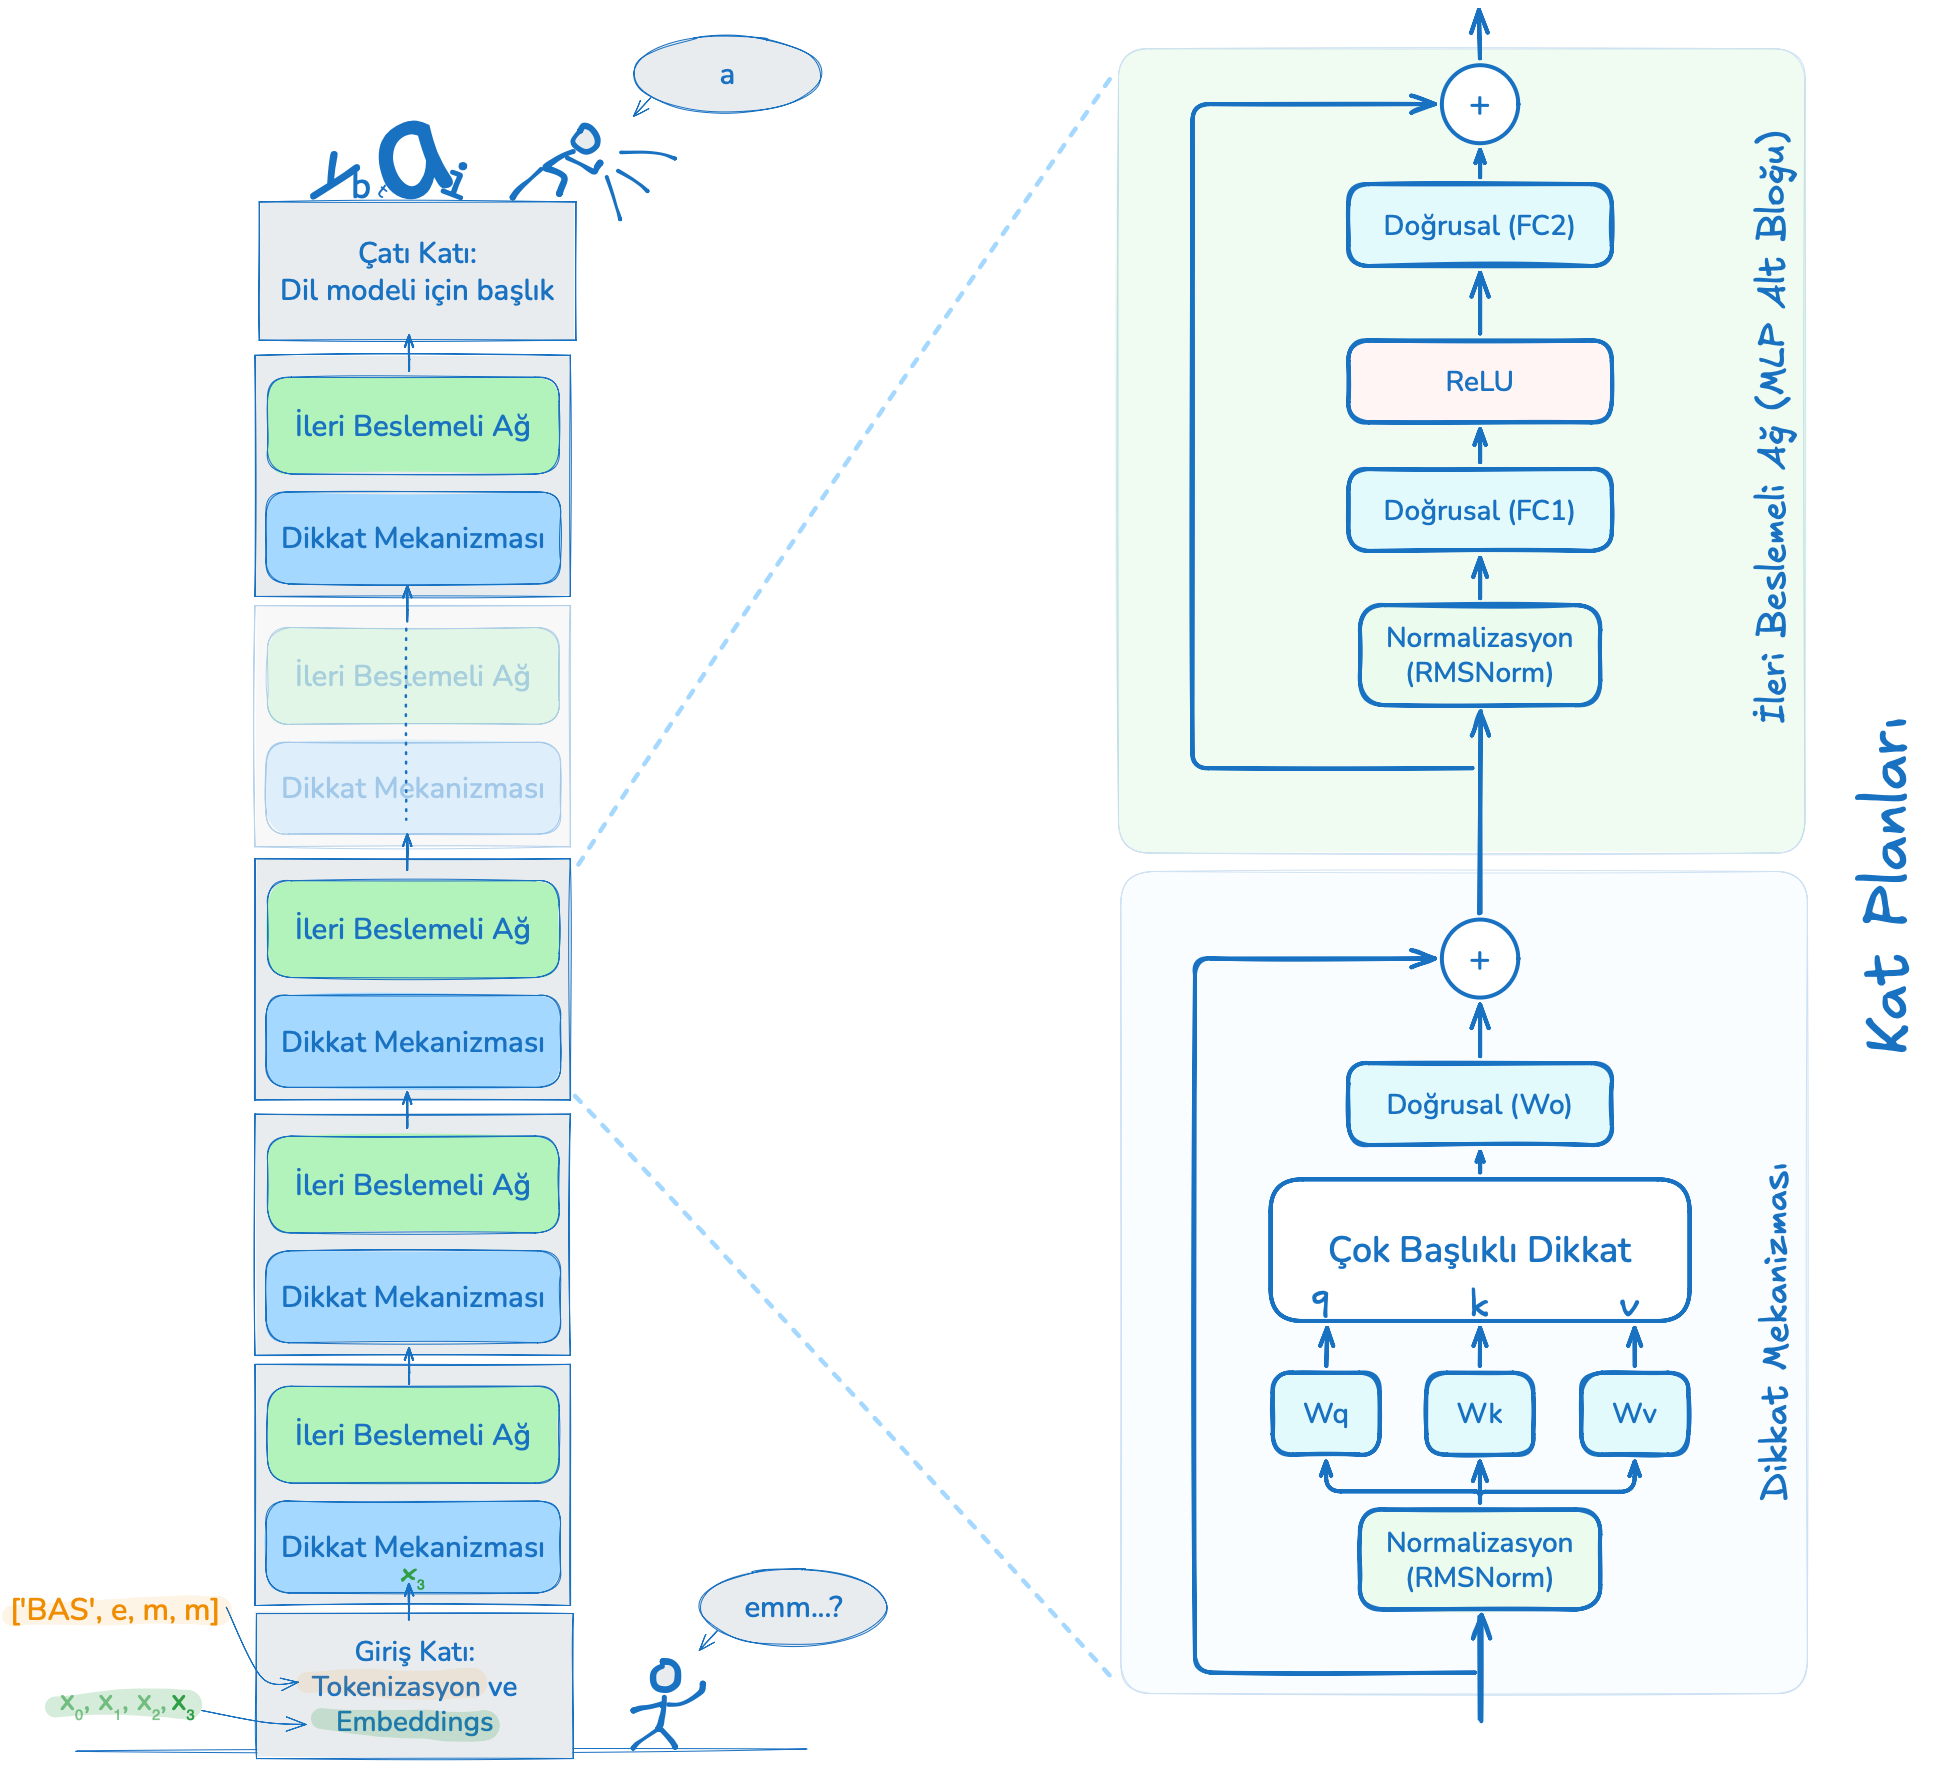

In [8]:
for k, m in state_dict.items():
    print(f"{k}: {len(m)} x {len(m[0])}")

wte: 27 x 16
wpe: 16 x 16
lm_head: 27 x 16
layer0.attn_wq: 16 x 16
layer0.attn_wk: 16 x 16
layer0.attn_wv: 16 x 16
layer0.attn_wo: 16 x 16
layer0.mlp_fc1: 64 x 16
layer0.mlp_fc2: 16 x 64


`wte` matrisinde (27 x 16) her token id için bir satır var ve her satırın boyutu embedding boyutu kadar. Basit bir yöntemler her satırı farklı bir token_id'ye atayacağız (`tok_emb`). Peki bu sayıları nereden gelecek? Eğitim sırasında öğrenilen parametreler olduğu için eğitimde kendiliğinden oluşacaklar.

Aynısı pozisyon vektörleri için de gerekli. En fazla `block_size = 16` harflik dizilerle çalışacağız demiştik. `wpe` matrisinde her sıra numarası için 16'lık bir vektör var. Dizideki kaçıncı tokendeysek o satırdaki vektörü pozisyon vektörü olarak kullanıyoruz (`pos_emb`).

Bloklara aktaracağımız vektör ise bu iki vektörün toplamı. Yani tek bir vektörde hangi harf (token) hangi sırada gibi bir bilgiyi temsil ediyoruz. Bu vektörü `rmsnorm(x)` fonksiyonumuz ile normalize ettikten sonra artık ilk kata aktarabiliriz.

### Blok tanımı
Bir `for` döngüsü ile `n_layer` adet transformer bloğunu, yani katları tanımlamaya başlayalım. Bu katların her biri birbirinin aynısı olacak. Her katta iki oda olduğunu hayal edelim. İlk oda **Multi-head attention alt bloğu** olarak isimlendirilen bölüm. İkincisi ise **MLP alt bloğu**.

Bu alt bloğa girerken yol ikiye ayrılıyor. Bir yol Attention alt bloğuna girerken diğer yol attention'ı pas geçerek yola düz devam ediyor. İşte bu düz devam eden bağlantıya `x_residual` dedik. Attention çıkışında bunlar tekrar birleşecekler. Bu pratikte öğrenmeyi oldukça kolaylaştıran bir teknik. Böylece attentiondan geçen taraf x'i değil x'in üzerine eklenecek farkı (residual) öğreniyor. Yani bu kısım 0 olduğunda bile (yol tıkalı mesela) alt kattan gelen x vektörü bozulmadan yoluna devam edebilecek (identity function, özdeş fonksiyon).

#### Dikkat Mekanizması

Buradaki dikkat mekanizması Transformerları diğer mimarilerden ayıran en temel şey. Aynı zamanda ilk başka en gizemli görünen ve anlaşılması zaman alan bir yapı. İşin aslı göründüğünden çok daha kolay ve şimdi bunu öğreneceğiz.

Buradaki fikir aslında basit. Elimizde bir vektör (`x`) var. Bu vektör giriş katında bir harf ve bunun pozisyon bilgisinden üretilmişti ve her katta değişikliğe uğrayarak (dönüşerek) yoluna devam ediyordu. Diyelim 'emma' kelimesinin 3. harfindeyiz. Bunu kendinden önceki e ve m'den dönüştürülen, yani 1. ve 2. sıradaki vektörlerle karşılaştırıyoruz.

Peki nasıl karşılaştıracağız?

Matematikte iki vektörü karşılaştırmanın, yani benzerliğini ölçmenin en basit yolu **iç çarpım**dır (**dot product**).

Aslında bu vektörleri sırayla alıp birbiriyle iç çarpımlarını alarak karşılaştırabiliriz. Mesela ilk sıradaki vektörle ($x_1$) 3. sıradaki vektörün  ($x_3$) ne kadar benzediğini gösteren bir sayı elde ederiz. Burada yapacağımız şey ise bunun bir adım ilerisi olacak. Doğrudan $x_1$ ve $x_3$'ün iç çarpımını almak yerine, bunları öğrendiğimiz parametrelerden oluşan akıllı matrislerimiz ile çarparak yeni vektörler elde edeceğiz ($k_1$ ve $q_3$) ve yeni vektörleri karşılaştıracağız. Diğer bir ifadeyle öğrenilmiş, akıllı ve girdilere göre değişen bir karşılaştırma yöntemi kullanacağız.

**Matris-vektör çarpımı**nı `linear(x, W)` fonksiyonuyla tanımlamıştık. Biz elimizdeki $x$ vektörünü öğrenilmiş $W_{Q_{li}}$ matrisiyle projekt ederek (çarparak) $q$ vektörüne çeviriyoruz. Bu matrisler her blok yani her kat için ayrı ayrı. `li` numaralı blok için `layer{li}.attn_wq` matrisini kullanacağız:

```q = linear(x, state_dict[f'layer{li}.attn_wq'])```

Karşılaştırma yapılacak diğer (önceki) vektörü ise yine benzer bir matrisle $W_{K_{li}}$ çarparak $k_1$ vektörüne çeviriyoruz. Karşılaştırmayı da $x_1 \cdot x_3$ yerine daha akıllı $k_1 \cdot q_3$ şeklinde yapıyoruz. Bu çarpım bize skaler tek bir sayı veriyor. Bu sayıya **dikkat skoru** diyebiliriz. İki vektör arasındaki öğrenilmiş bir tür matematiksel ilişkiyi puanlıyor.

Elimizde sadece $x_3$ varsa $k_1$'i nereden bulduk diyebilirsiniz. KV-cache işte tam bu işe yarıyor. gtp fonksiyonuna girdi olarak $x_1$ verildiği zaman $q_1$, $k_1$ ve $v_1$ değerlerini hesaplıyor. $k_1$ ve $v_1$ değerlerini gelecekte kullanılmak üzere KV-cache'e (Anahtar-Değer önbelleği) kaydediyor. Kodda KV-önbelleği `keys` ve `values` adlı dictionaryler ile sağlanmış.

#### Multi-head attention (Çok Başlıklı Dikkat) alt bloğu
Bu kodda çok başlıklı dikkat normalden biraz farklı görünse de matematiksel olarak aynı. Normalde her başlık kendine ait daha küçük W matrisleri ile kendi 4 boyutlu q, v ve k'larını oluşturabilirdi. Burada ise bunu tek bir büyük matrisle yapıyoruz.

Burada her başlığın görevi bu dikkat işlemini farklı bir bakış açısıyla, diğerlerinden bağımsız olarak yapmak. Her biri kendi 4 boyutlu alt uzayında çalışıyor. Daha sonra 4 adet başlığın çıktısı birleştirilerek 16'lık tek bir vektör oluşturuyoruz.

#### Dikkat Fonksiyonu

Dikkat'i bir tek bir fonksiyon olarak düşünmek işimizi kolaylaştıracak. Aşağıdaki resimde bu fonksiyonun detaylı açıklamasını göreceksiniz. Burada yukarıda konuştuğumuzdan farklı olark dikkati hedapladığımız k vektörünün boyutunun (head_dim'e eşit) kareköküke bölme işlemi görüyoruz. Bunun sebebi, $q \cdot k_j$ vektörün varyansının vektör boyutuyla (head_dim) doğru orantılı artması (yaklaşık olarak). Standart sapmayı sabit tutmak için ise bunun kareköküne bölüyoruz (standart sapma varyansın karekökü). Böylece softmaxa girecek olan skor değerleri birbirine daha yakın kalıyor. Bu da eğitimi kolaylaştırıyor.

Tekrar özetlemek gerekirse, q'nun, elimizdeki bütün k vektörleriyle iç çarpımını hesaplayarak benzerliklerine baktık. Bu çarpımları vektör boyutunu kareköküne bölerek ölçeklendirdik ki standart sapma sabit kalsın. Bu dikkat skorlarını softmax fonsiyonundan geçirerek dikkat apırlıklarını elde ettik. Hatırlayın, softmax [-sonsuz, + sonsuz] arasindak' sayilari toplamlari 1 olacak şekilde [0, 1] aralığına ölçekliyordu. Bu ağırlıkları kullanarak v vektörlerinin ağırlıklı toplamını alıyoruz. Yani elimizdeki bütün v'leri ağırlıklarla orantılı olarak karıştırıyoruz. Dikkat fonksiyonunun çıktısı işte bu yeni yarattığımız karışmış vektör oluyor.

Dikkat fonksiyonunun diğer kaynaklarda bulabileceğiniz matematiksel ifadesini ve kodla ilişkisin aşağıda görselleştirdim. Bu mekanizmayı tek bir işlem bloğu gibi düşünüp başka modeller yaparken de kullanabiliriz. Transformer'ın özelliği dikkat dışında neredeyse hiçbir şey kullanmaması. İlk kez tanıtıldığı meşhur makalenin isminin **Tek İhtiyacınız Dikkat** (**Attention is All You Need**, 2017) olması boşuna değil.

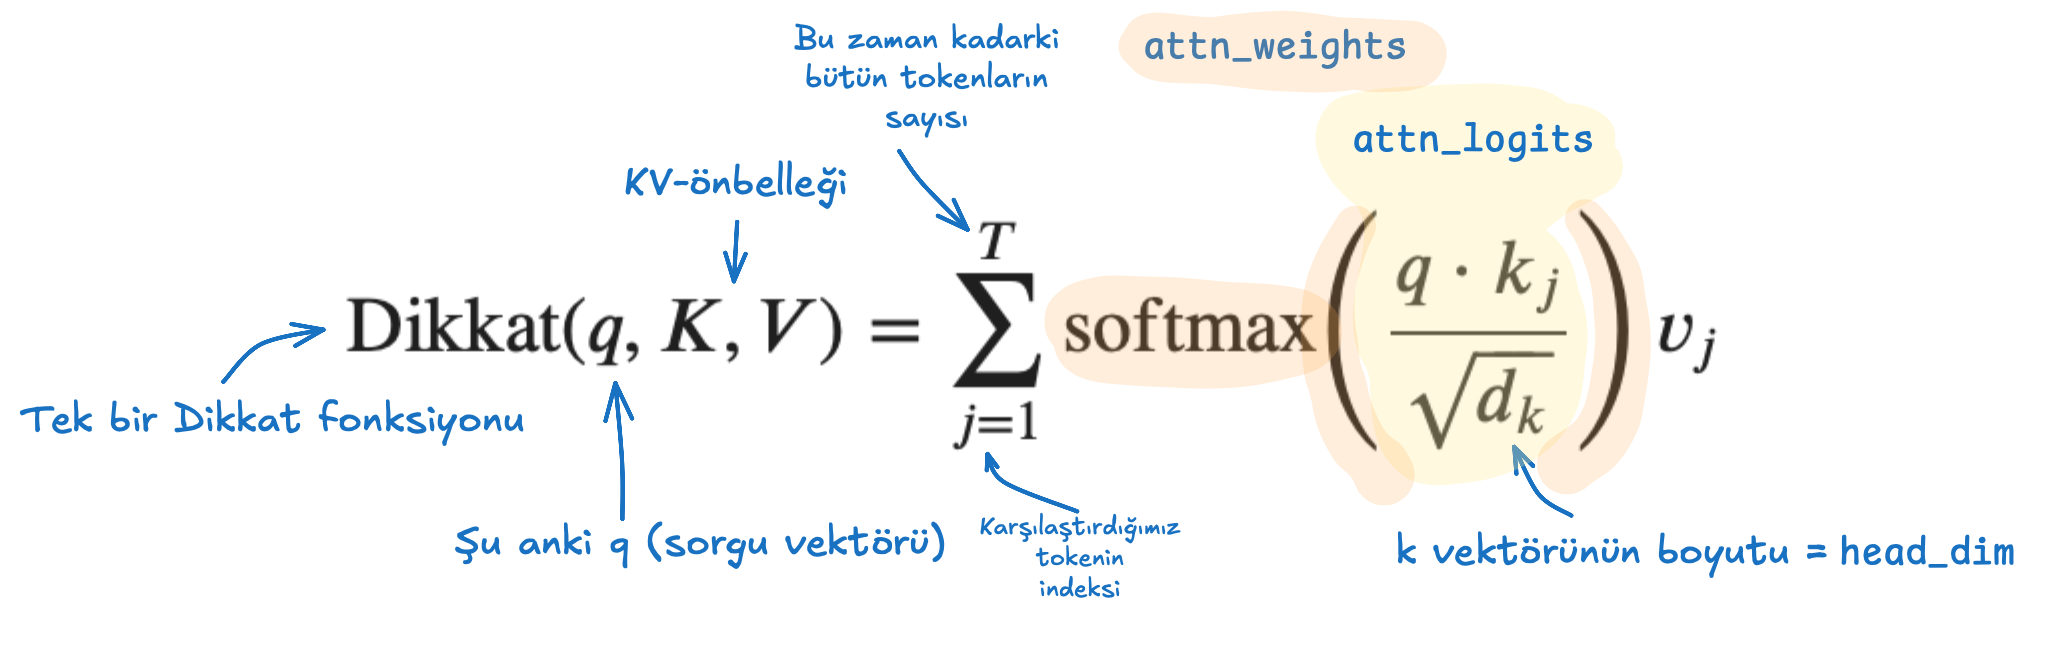

#### MLP Alt Bloğu
Dikkat bölümünde farklı tokenlardan türettiğimiz vektörleri birbirine karıştırdık. Bu alt blokta ise bulunduğumuz tokena ait vektörü kendi içinde işleyeceğiz. Bunun için de tek gizli katmanı olan, tam bağlantılı katmanlardan oluşan basit bir sinirsel ağ kullanıyoruz. Aktivasyon fonksiyonu olarak yukarıda tanımladığımız `relu(x)` fonksiyonunu kullanacağız. Relu negatif değerleri 0 yapan, pozitif değerleri ise olduğu gibi bırakan basit bir fonksiyon. Ancak yaptığımız işlemleri doğrusal olmaktan çıkardığı için işlevi büyük. Eğer bu olmasaydı iki lineer katmanı matris çarpımıyla tek bir matriste birleştirebilecektik. Bu da sadece lineer fonksiyonları modelleyebileceğimiz anlamına gelecekti.

`x_residual` numarasını burada da kullanacağız. Yani bu bloğun çıkışına bağlanan kestirme bir yol ekleyeceğiz. Gradyanlar bu yollardan da aktığı için çok daha derin modelleri eğitebilmemize yardımcı oluyor.

#### Çatı Katı - Model Çıktısı
Bütün katları yani transformer bloklarını tanımladık. Şimdi modelimizin çıktısını tasarlamaya geldi sıra. Burada da aslında serbestiz ama basit bir şekilde `lm_head` matrisinin tanımladığı doğrusal katmanla tek bir başlık ekleyeceğiz. Bu 16 boyutlu x vektörümüzü 27 boyutlu logitlere çevirecek. Hatırlayalım, sözlük boyutumuz 27'ydi (26 harf + BAS). `lm_head` matrisinin boyutu 27x16. Oluşan 27 boyutlu `logits` vektörü bize her karakterin olasılığıyla orantılı bir sayı verecek.

In [9]:

def gpt(token_id, pos_id, keys, values):
    # Giriş katı
    tok_emb = state_dict['wte'][token_id] # token embedding’i
    pos_emb = state_dict['wpe'][pos_id] # pozisyon embedding’i
    x = [t + p for t, p in zip(tok_emb, pos_emb)] # token + pozisyon embedding’i
    x = rmsnorm(x) # normalize et

    for li in range(n_layer): # n_layer tane transformer bloğu
        # 1) Multi-head attention alt bloğu
        x_residual = x # yol ayrımı. x_residual değişmeden doğrudan dikkat çıktısına bağlanacak
        x = rmsnorm(x) # LayerNorm alternatifi rms normalizasyonu

        # q (sorgu), k (anahtar) ve v (değer) vektörlerini x'ten türet
        q = linear(x, state_dict[f'layer{li}.attn_wq']) # W_Q x
        k = linear(x, state_dict[f'layer{li}.attn_wk']) # W_K x
        v = linear(x, state_dict[f'layer{li}.attn_wv']) # W_V x

        # KV-cache: Anahtar-Değer önbelleği
        keys[li].append(k)   # k_li anahtarını listede sakla
        values[li].append(v) # v_li anahtarını listede sakla

        # Çok Başlıklı Dikkat
        x_attn = [] # dikkat alt bloğunun çıktısı. (n_head = 4) başlığın her biri (head_dim = 16 / 4) vektörden sorumlu.
        for h in range(n_head): # her başlık için
            hs = h * head_dim   # n'inci head için başlangıç indeksi
            q_h = q[hs:hs+head_dim]                        # h numaralı başlığa ait head_dim boyutlu q
            k_h = [ki[hs:hs+head_dim] for ki in keys[li]]  # h numaralı başlığa ait head_dim boyutlu k
            v_h = [vi[hs:hs+head_dim] for vi in values[li]] # h numaralı başlığa ait head_dim boyutlu v
            attn_logits = [sum(q_h[j] * k_h[t][j] for j in range(head_dim)) / head_dim**0.5 for t in range(len(k_h))] # dikkat skorları (logitler)
            attn_weights = softmax(attn_logits) # normalize edilmiş dikkat ağırlıkları
            head_out = [sum(attn_weights[t] * v_h[t][j] for t in range(len(v_h))) for j in range(head_dim)] # v vektörlerinin dikkat ağırlıklarıyla ağırlıklı ortalaması alındı.
            x_attn.extend(head_out) # bu head için dikat çıktısını (karıştırılmış v vektörlerini) ortak dikkat çıktısına ekle
        x = linear(x_attn, state_dict[f'layer{li}.attn_wo']) # çıktıyı bir lineer katmandan geçir (W_o)
        x = [a + b for a, b in zip(x, x_residual)]           # yol birleşimi. x + x_residual şeklinde toplama ile birleşiyor.

        # 2) MLP alt bloğu
        x_residual = x # tekrar yol ayrımı. x_residual değişmeden devam edip MLP alt bloğu çıktısı ile bileşecek
        x = rmsnorm(x) # LayerNorm alternatifi rms normalizasyonu
        x = linear(x, state_dict[f'layer{li}.mlp_fc1']) # ilk MLP katmanı. Fully Connected (FC, Tam Bağlantılı) bir doğrusal katman ve
        x = [xi.relu() for xi in x]                     # doğrusal olmayan aktivasyon fonksiyonu olarak (Non-Linear Activation) olarak ReLU
        x = linear(x, state_dict[f'layer{li}.mlp_fc2']) # aynısından bir FC katman daha. Bu sefer aktivasyon yok.
        x = [a + b for a, b in zip(x, x_residual)] # yol birleşimi aynı şekilde toplama ile

    # Bütün blokları gezdik.
    # Çatı Katı: Son katta oluşan vektörü çıktı olarak kullanılacak logitlere dönüştürmek için bir doğrusal katman daha.
    logits = linear(x, state_dict['lm_head']) # 16 boyutlu gömülü vektörü 27 boyutlu (her token çeşidi için bir sayı) çıktıya çevir.
    return logits # normalize edildiğinde olasılık yerine kullanılabilecek 27 adet skor dönüyoruz.


## Eğitim
Eğitim'e başlamak için neredeyse her şey hazır. Optimizasyon için popüler **ADAM (Adaptive Moment Estimation, Uyarlamalı Momement Tahmini)** yöntemini kullanacağız. Eğitim sırasında **Kayıp** değerini (**Loss**) azaltacak şekilde parametreleri değiştireceğimizi söylemiştik. Bunu da **gradyan**ları kullanarak yapacaktık. **Gradyan vektörü** bize **Kaybı artıran doğrultu**yu gösteriyor. Bu vektörün tersi yönde ufak adımlar atarak Kayıp değerini düşürmeye çalışacağız.

Bunu sisli bir havada dağdan aşağı inmeye çalışan bir dağcı olarak hayal edebilirsiniz. Görebildiği yakın çevresindeki zeminin eğimine bakarak en çok aşağı yönde eğim olan tarafa doğru bir adım atsın. Her adımda eğini kontrol ederek en dik aşağı eğim olan yöne dönsün. Eğer dağda içine düşebileceği çukurlar yoksa bir şekilde aşağıya inecektir. Bu örnek kabaca **SGD**'ye (**Stochastic Gradient Descent, Rastgele Gradyan İnişi**) benzer.

### ADAM Optimizasyonu
**ADAM** ise bunun biraz daha akıllısı. Dağcımız her adımda ani yön değişikliği yapmak yerine önceki yönünü de biraz koruyor. Bunun için iki tane vektörü (moment) hafızada tutacağız. İlki momentum (m) vektörü. Bu önceki gradyanların üstel hareketli ortalaması. Yani eski değerler giderek daha az katkı sağlıyor. `beta1` hiperparametresi burada 0.85 olarak seçilmiş ve bu azalma miktarını belirliyor:

```python
m[i] = beta1 * m[i] + (1 - beta1) * p.grad
```
Bu momemntum yöntemi tek başına da kullanılabilir. Ancak ADAM yönteminde bu momentumun yanına  RMSprop yönteminden gelen ve gradyanın karesine bağlı ikinci bir moment daha ekliyoruz:
```
v[i] = beta2 * v[i] + (1 - beta2) * p.grad ** 2
```
Bu iki değer ilk adımlarda 0 gelecek. Bunu düzeltmek için **Sapma Düzeltmesi** (**Bias Correction**) denen bir iyileştirme yapıyoruz.
$$\hat{m}_t
=
\frac{m_t}{1 - \beta_1^t}$$
$$\hat{v}_t
=
\frac{v_t}{1 - \beta_2^t}$$

Parametreyi bunları kullanarak şu şekilde güncelleyeceğiz:
$$\theta_{t+1}
=
\theta_t
-
\eta
\frac{\hat{m}_t}
{\sqrt{\hat{v}_t} + \epsilon}$$
Burada $\theta_t$ güncellenecek parametre, $\eta$ bizim belirlediğimiz öğrenme oranı (`learning_rate`), $\epsilon$ sıfıra bölmeyi engellemek için çok küçük bir değer. Koddaki satır bunun aynısı:

```p.data -= lr_t * m_hat / (v_hat ** 0.5 + eps_adam)```

### Eğitim Hedefi

Bildiğiniz gibi, şu ana kadar üretilen tokenleri girdi olarak verip sıradaki tokeni tahmin etmek istiyoruz. Bir dizideki değerleri geçmişte çıkmış değerlere bakarak üretme yöntemine teknik olarak **Otoregresyon (Autoregression)**, bu tür bir modele de **Otoregresif (Autoregressive)** model diyoruz. **Üretken (Generative)** Modellerde kullanılan yöntemlerden biri bu, ama elbette başka yöntemler de var. Dil modelleri ve gpt bağlamında buna **Next Token Prediction (Sonraki Token Tahmini)** deniyor.

`gpt()` fonsiyonumuz en son üretilen tokeni (harfi), bunun dizi içindeki sırasını ve geşmişte çıkan harfleri KV-önbelleğini alıyordu. Çıktı olarak ise bir sonraki tokenin hangisi olduğunun olasılığıyla orantılı sayılar dönüyordu (`logits`). Eğitim veri setinde doğru cevabı, yani sonraki harfin ne olması gerektiğini biliyoruz. Kodda bu do[ru cevaba  `target_id` diyeceğiz. Örneğin 'emma' ismi için 'emm' girdisi verildiğinde  modelin a'ya en yüksek logiti dönmesini istiyoruz (`target_id` = 'a'nin token id'si).

### Kayıp Fonksiyonu
En kritik noktalardan birine geldik. Meşhur kayıp fonksiyonumuzu tanımlayacağız. Bu bize hangi ölçüye göre parametreleri optimize edeceğimizi gösterecek. Yani modelimize neyi öğrenmesini istediğimizi söyleyeceğiz.  `target_id`'yi yukarıda tanımlamıştık. Modelimizin bu hedefe ne kadar ulaştığını kayıp fonksiyonumuz ölçecek.

Öncelikle `gpt()`'nin döndüğü `logit`leri **olasılık**lara (toplamları 1 olacak şekilde [0, 1] arası sayılar) çevirmek için yine `softmax` fonksiyonumuzu kullanıyoruz.

Burada kullanacağımız kayıp fonksiyonu **Cross Entropy Loss (Çapraz Entropi Kaybı)** diye geçiyor ve **çoklu sınıflandırma** görevlerinde sık kullanılıyor.
$$L =
- \sum_{i=1}^{C}
y_i \log(\hat{y}_i)$$

(Alfabedeki C farklı token için; $y_i$ bir tokenin gerçek olasılığını, $\hat{y}$ ise aynı tokene modelin atadığı olasılığı gösteriyor.

İdeal durumda modelimiz doğru cevap için, yani `target_id` için 1.0 olasılığı, diğer bütün tokenler için ise 0.0 olasılığını dönmeli. Bu durumda Çapraz Entropi sadeleşerek **log-loss**'a (**logaritmik kayıp**) dönüşüyor.

$$L = -\log(\hat{y}_{k})$$

Veya kod olarak:
```loss_t = -probs[target_id].log()```

Bunun ne yaptığını anlamaya çalışalım. Eğer modelimiz mükemmel çalışır ve `target_id` için `1.0` olasılığı dönerse, $log(1) = 0$ olduğu için kayıp sıfır olacak.

Tersine modelimiz kötü çalışır ve 1.0 yerine 0 a yakın bir olasılık dönerse log(p) eksi sonsuza, -log(p) ise artı sonsuza yaklaşacak (log(0) tanımsız).

Pratikte yanlış cevaplar için kayıp yüksek bir sayı vererek modeli uyarıyor, doğruya yaklaşan cevaplarda da 0'a yakın kayıp hesaplıyoruz. Yapmak istediğimiz şey de buydu.

Modelin hiçbir şey öğrenmeden rastgele tahminde bulunduğunu düşünelim. 27 seçenek olduğu için doğru tutturma olasılığı 1/27. `-log(1/27) = 3.3` (log $e$ tabanlı doğal logaritma). Yani rastgele sallayan bir modelin kayıp değeri 3.3 olmalı ve öğrendikçe bu değer azalmalı. Bunu aşağıdaki eğitimi çalıştırdığınızda kendiniz kontrol etmeyi unutmayın.

Son olarak, isimdeki her token için sırayla hesapladığımız kayıp değerlerinin ortalamasını alıyoruz. Bu değer bizim asıl kayıp değerimiz oluyor. `loss.backward()` ile model boyunca geriye giderek bu kayba göre gradyanları hesaplatıyoruz. Loss da dahil olmak üzere gpt'nin yarattığı ve döndürdüğü  `Value` nesneleri ile yaptığımız bütün matematik işlemlerinin yerel türevleri **Hesaplama Grafiğine (Computational Graph)** otomatik olarak kaydedildi. `loss` bu grafiğin en sonundaki `Value` nesnesi olduğu için bunun üzerinden çağrılan `loss.backward()`, bütün `.grad` değerlerini lossa göre hesaplayacak.

 Sonrasında **ADAM** bu hesaplanan gradyanlara bakarak parametreleri kaybı düşürecek yönde güncelliyor. Ve sonraki eğitim **adım**ına geçip **kayıp hesaplama** ve **parametre güncelleme** işlemlerini tekrar ediyoruz. Bu örnekte her adımda farklı 1 isim için kayıp hesaplandığından her adımda kayıp düşüyor gibi görünmese bile, eğitim ilerledikçe kaybın azaldığını göreceksiniz.

In [10]:
# ADAM olsun, kutsanmış optimize edici
learning_rate, beta1, beta2, eps_adam = 0.01, 0.85, 0.99, 1e-8 # ADAM hiperparametreleri
m = [0.0] * len(params) # birinci moment
v = [0.0] * len(params) # ikinci moment

# Sırayla tekrarla
num_steps = 1000 # eğitim adımı sayısı
for step in range(num_steps):

    # Tek bir doküman al, tokenize et, iki yanına BAS özel token’ını koy
    doc = docs[step % len(docs)] # her eğitim adımında 1 döküman işliyoruz (batch büyüklüğü = 1)
    tokens = [BAS] + [uchars.index(ch) for ch in doc] + [BAS] #  Tokenleri oluştur (Harfin uchars listesi içindeki sırası o harfin token id'sini veriyor)
    n = min(block_size, len(tokens) - 1) # dizi boyutu (en fazla block_size = 16)
    # Token dizisini modelden geçir, kayba kadar tüm hesaplama grafiğini kur.
    keys, values = [[] for _ in range(n_layer)], [[] for _ in range(n_layer)]
    losses = [] # Dizi boyunca her token için hesaplanacak kayıpların listesi
    for pos_id in range(n): # dizi boyunca pozisyonları gez
        token_id, target_id = tokens[pos_id], tokens[pos_id + 1] # şimdiki token ve bir sonraki token. bir sonraki token target (eğitim hedefi) olacak.
        logits = gpt(token_id, pos_id, keys, values) # gpt modelimizi şimdiki tokeni ve pozisyonunu vererek ileri yönlü çalıştır. gelecek token tahmini için logitleri dönecek.
        probs = softmax(logits) # Softmax ile logitleri toplamları 1.0 olan olasılık değerlerine çevir.
        loss_t = -probs[target_id].log() # KAYIP Fonksiyonu: Çapraz Entropi (Cross Entropy). Doğru target için modelin verdiği olasılıpın negatif logu.
        losses.append(loss_t) # kayıplar listesine ekle
    loss = (1 / n) * sum(losses) # doküman dizisi üzerindeki nihai ortalama kayıp. Düşük olsun.

    # Kaybı geri yay, tüm model parametrelerine göre gradyanları hesapla.
    loss.backward()

    # Adam güncellemesi: gradyanlara göre model parametrelerini güncelle.
    lr_t = learning_rate * (1 - step / num_steps) # doğrusal öğrenme oranı azaltımı
    for i, p in enumerate(params):
        m[i] = beta1 * m[i] + (1 - beta1) * p.grad # birinci moment. momentum.
        v[i] = beta2 * v[i] + (1 - beta2) * p.grad ** 2 # ikinci moment
        m_hat = m[i] / (1 - beta1 ** (step + 1)) # birinci moment sapma duzeltmesi
        v_hat = v[i] / (1 - beta2 ** (step + 1)) # ikinci moment sapma duzeltmesi
        p.data -= lr_t * m_hat / (v_hat ** 0.5 + eps_adam) # parametre güncellemesi
        p.grad = 0 # sonraki eğitim adımı için gradyanı sıfırla

    print(f"adım {step+1:4d} / {num_steps:4d} | kayıp {loss.data:.4f}, tokenler: {tokens}")


adım    1 / 1000 | kayıp 3.3660, tokenler: [26, 24, 20, 7, 4, 13, 6, 26]
adım    2 / 1000 | kayıp 3.4243, tokenler: [26, 3, 8, 14, 13, 3, 17, 4, 26]
adım    3 / 1000 | kayıp 3.1778, tokenler: [26, 23, 0, 21, 8, 4, 13, 26]
adım    4 / 1000 | kayıp 3.0664, tokenler: [26, 9, 14, 17, 8, 26]
adım    5 / 1000 | kayıp 3.2209, tokenler: [26, 9, 20, 0, 13, 11, 20, 8, 18, 26]
adım    6 / 1000 | kayıp 2.9452, tokenler: [26, 4, 17, 0, 13, 3, 8, 26]
adım    7 / 1000 | kayıp 3.2894, tokenler: [26, 15, 7, 8, 0, 26]
adım    8 / 1000 | kayıp 3.3245, tokenler: [26, 18, 0, 12, 0, 19, 7, 0, 26]
adım    9 / 1000 | kayıp 2.8990, tokenler: [26, 15, 7, 14, 4, 13, 8, 23, 26]
adım   10 / 1000 | kayıp 3.2229, tokenler: [26, 4, 12, 12, 4, 11, 24, 13, 13, 26]
adım   11 / 1000 | kayıp 2.7964, tokenler: [26, 7, 14, 11, 11, 0, 13, 26]
adım   12 / 1000 | kayıp 2.9345, tokenler: [26, 7, 14, 11, 11, 8, 18, 26]
adım   13 / 1000 | kayıp 3.0544, tokenler: [26, 2, 0, 11, 11, 0, 11, 8, 11, 24, 26]
adım   14 / 1000 | kayıp 3.

## Çıkarım
**Çıkarım** (**Inference** veya **Generation**) için eğitimdekine benzer şekilde yine `gpt()` fonksiyonunu kullanacağız. Yeni bir isim üretmesi için girdi olarak 'BAS' (dizi başlangıcı, 26 id'li token) tokenini veriyoruz. Hatırlarsanız eğitimde de her ismin başına ve sonuna bu tokenden koymuştuk.

`gpt`'nin döndürdüğü logitleri yine softmax ile olasılığa döndüreceğiz. Fakat burada ufak bir farklılık var: `temperature` (**Sıcaklık**) parametresi. Bu sıcaklık parametresini yükseltmek olasılık dağılımını biraz daha rastgele hale getiriyor. `temperature = 1` olursa eğitimde kullandığımız dağılımın aynısı olacak. 1'den küçük değerler dağılımı daha çok keskinleştirecek, yani büyük değerlere daha çok olasılık atayacak. Sıcaklık sıfıra yakşatıkça maksimum dışındaki her tokenin olasılığı sıfıra yaklaşacak. Sıcaklık büyük bir sayı olduğunda ise tersine, **Uniform (Düzgün) dağılım**a benzemeye başlayacak ve her tokenin seçilme şansı artacak.

Sonrasında, `random.choices` ile oluşturduğumuz bu **olasılık dağılımını kullanarak** bir harf örnekliyoruz.

Bunu harf üretme işini BAS tokeni gelene veya `block_size = 16` sınırına ulaşana kadar tekrar ettiğimizde ismimiz üretilmiş.

In [11]:
# Çıkarım (Inference): model bize geri “gevezelesin”
temperature = 0.5 # (0, 1] aralığında, üretilen metnin “yaratıcılığını” kontrol eder, düşükten yükseğe
print("\n--- çıkarım (yeni, halüsinasyon isimler) ---")
for sample_idx in range(20): # üretilecek örnek (isim) sayısı
    keys, values = [[] for _ in range(n_layer)], [[] for _ in range(n_layer)] # KV-önbelleğini boş olarak yarat
    token_id = BAS # Dizi Başlangıç tokeni ile başlıyoruz
    sample = [] # üreteceğimiz isim, harf listesi olarak tutulacak
    for pos_id in range(block_size): # en fazla 16 tokenlik dizi üret
        logits = gpt(token_id, pos_id, keys, values) # eldeki en yeni tokenle gpt'yi çağır ve logitleri üret
        probs = softmax([l / temperature for l in logits]) # Sıcaklık kullanarak olasılıkları hesapla: softmax(logits/T)
        token_id = random.choices(range(vocab_size), weights=[p.data for p in probs])[0] # olasılık dağılımına göre bir token örnekle
        if token_id == BAS: # BAS tokeni gelirse üretilen isim tamamlandı demektir
            break
        sample.append(uchars[token_id]) # üretilen token id'yi harfe çevir ve sonuç listesine ekle
    print(f"örnek {sample_idx+1:2d}: {''.join(sample)}") # üretilen ismi yazdır


--- çıkarım (yeni, halüsinasyon isimler) ---
örnek  1: kamon
örnek  2: ann
örnek  3: karai
örnek  4: jaire
örnek  5: vialan
örnek  6: karia
örnek  7: yeran
örnek  8: anna
örnek  9: areli
örnek 10: kaina
örnek 11: konna
örnek 12: keylen
örnek 13: liole
örnek 14: alerin
örnek 15: earan
örnek 16: lenne
örnek 17: kana
örnek 18: lara
örnek 19: alela
örnek 20: anton


## Sonuç ve Notlar

Hayırlı olsun, iki gpt'nizi eğittiniz 🎉

Bu arada çok basitleştirilmiş olsa da, CPU'da çalıştığı için ne kadar yavaş çalıştığını da gördünüz.

GPU veya TPU gibi özelleşmiş işlemcilerin kullanılmasını sebebi yukarıda tanımladığımız matris çarpımı gibi işlemleri bu işlemcilerde paralel olarak çok daha hızlı yapabilmemiz. Ayrıca burada her adımda sadece bir isim için eğittik. Örneğin bir adet H100 GPU içinde, bu tür matris çarpımı gibi işlemler için özelleşmiş 528 tane Tensor Core, genel matematiksel işlemler için de 16896 adet CUDA çekirdeği var. Bunların her birini basit işlemciler olarak düşünebilirsiniz. Hepsi aynı anda paralel olarak çalışıyor, ve her biri yukarıdaki işlemlerin belli bir kısmını bağımsız olarak yapıyor.

Gerçek sistemlerin bu örnekten farkının daha kapsamlı bir anlatımı için [Karphaty'nin blog yazısı](https://https://karpathy.github.io/2026/02/12/microgpt/)'na bakabilirsiniz. Bunların bir çoğu yukarıda yaptığımız şeyi devasa ölçeklere çıkarmak için kullanılan mühendislik tekninkleri. İşin temeli ve matematiği neredeyse hiç değişmiyor. Dolayısıyla bu temelleri iyi kavramış olmak diğer her şeye açılan kapı.

Son olarak, umarım şu mesajı verebilmişimdir. GPT gibi modern Yapay Zeka modelleri ne mucizevi ve anlaşılmaz şeyler, ne de hafife alınması gereken şeyler. Elimizde basit prensiplere dayanan, ama çok güçlü, çok fazla karmaşıklaşmaya uygun bir makine var. Aldatıcı basitliğinin arkasında insanlığın ürettiği en karmaşık icatlardan biri gizleniyor. Gördüğünüz gibi bu temel prensipler sizin de rahatlıkla dokunabileceğiniz uzaklıkta. Ancak bir de buzdağının görünmeyen dev kısmı var ki oralara henüz hiçbir insan tam anlamıyla inebilmiş değil. Kim bilir, belki gelecekte oraya inenlerden biri de siz olursunuz.